# Lego Detection Model

## Imports

In [408]:
# from scripts.model import *

import cv2
import numpy as np
import os
import math
from sklearn.cluster import KMeans
from scripts.utils import *
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# 1. K-means clustering to get color regions
def kmeansBlur(img, blurQuantity = 3, clusterSize = 10):
    blurred = cv2.GaussianBlur(img, (blurQuantity, blurQuantity), 0)
    
    pixels = blurred.reshape((-1, 3))
    pixels = np.float32(pixels)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 1.0)
    _, labels, centers = cv2.kmeans(pixels, clusterSize, None, criteria, 20, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image = segmented_data.reshape((img.shape))
    
    return segmented_image    

def drawEdgeImg(img, edges):
    edge_mask = np.zeros_like(img)
    edge_mask[edges > 0] = (255, 255, 255)
    edge_image = cv2.bitwise_and(img, edge_mask)
    return edge_image

# 2. Get the edges of the image with Canny edge detection
def getEdges(img, cannyThreshold1 = 100, cannyThreshold2 = 200, showGray = False):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if(showGray):
        print("Gray Image")
        render(gray)
    edges = cv2.Canny(gray, cannyThreshold1, cannyThreshold2)
    edge_image = drawEdgeImg(img, edges)
    return edges, edge_image

# 3. Get the contours of the edges in the image
def getContours(img, edges, connectSize = 3):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (connectSize, connectSize))
    dilated_edges = cv2.dilate(edges, kernel)
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = img.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
    return contour_image, contours

# 4. Get the bounding boxes for the legos based on the contours edges
def getBoundingBoxes(img, contours, minPossibleArea = 100, intersectionThreshold = 0.2):
    
    num_legos = 0
    bounding_box_image = img.copy()
    bounding_rectangles = []

    for contour in contours:
        
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        
        # Ignore small area rectangles because they are likely noise
        if area < minPossibleArea:
            continue
        
        # Check if this bounding rectangle overlaps with any previously drawn ones
        overlap = False
        contained = False
        for (bx, by, bw, bh) in bounding_rectangles:
            intersection_area = max(0, min(x+w, bx+bw) - max(x, bx)) * max(0, min(y+h, by+bh) - max(y, by))
            union_area = area + bw*bh - intersection_area
            if intersection_area / union_area > intersectionThreshold:
                overlap = True
                # print("OVERLAP")
                break
            if x >= bx and y >= by and x + w <= bx + bw and y + h <= by + bh:
                contained = True
                # print("CONTAINED")
                break
        
        # If not fully contained and no significant overlap, draw the bounding box and increment lego count
        if not contained and not overlap:
            cv2.rectangle(bounding_box_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            bounding_rectangles.append((x, y, w, h))
            num_legos += 1
            
    return num_legos, bounding_box_image, bounding_rectangles


# 5.1. Get the main frequency colors of the original image
def getMainColors(img, blurQuantity = 3, numColors = 200, showHistogram = False):
    blurred = cv2.GaussianBlur(img, (blurQuantity, blurQuantity), 0)
    bgr = cv2.cvtColor(blurred, cv2.COLOR_RGB2BGR)
    pixels = bgr.reshape(-1, 3)
    pixel_tuples = [tuple(pixel) for pixel in pixels]

    # Get the most common colors
    color_counter = Counter(pixel_tuples)
    most_common_colors = color_counter.most_common(numColors)
    colors, counts = zip(*most_common_colors)
    colors = np.array(colors)
    
    if showHistogram:
        print("Most common colors histogram")
        plt.bar(range(len(colors)), counts, color=colors/255)
        # make plt bigger
        plt.show()
        
    return colors

# 5.2 Get the image contained in a bounding box
def getBoundingBoxImage(img, box):
    x, y, w, h = box
    cropped_image = img[y:y+h, x:x+w]
    return cropped_image
   

# 5.3. Remove the main colors of the image from the bounding boxes
def remove_similar_colors(img, most_common_colors, blurQuantity = 3, threshold_distance = 100):
    
    replacement_color = (254, 254, 254)
    new_img = img.copy()
    new_img = cv2.GaussianBlur(new_img, (blurQuantity, blurQuantity), 0)

    # Iterate over each pixel in the image and replace the pixel color if it is similar to one of the most common colors
    for y in range(new_img.shape[0]):
        for x in range(new_img.shape[1]):
            distances = [np.linalg.norm(np.array(new_img[y, x]) - np.array(color)) for color in most_common_colors]
            if min(distances) < threshold_distance:
                new_img[y, x] = replacement_color

    return new_img
    
# 5.4 Display a square of a specific color in RGB format
def display_color_square(color):
    color = (color[0] / 255, color[1] / 255, color[2] / 255)
    _, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    rectangle = plt.Rectangle((0, 0), 1, 1, color=color)
    ax.add_patch(rectangle)
    name = f"({color[0] * 255:.0f}, {color[1] * 255:.0f}, {color[2] * 255:.0f})"
    ax.text(0.5, 0.5, name, ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='white'))
    ax.axis('off')
    plt.show()   
    
def getLegoColor(lego_img, colorSimilarityThreshold = 1, numClusters = 5):

    most_frequent_colors = []
    most_frequent_colors.append((254, 254, 254))

    def color_distance(color1, color2):
        return np.sqrt(np.sum((color1 - color2) ** 2))
    
    bgr = cv2.cvtColor(lego_img, cv2.COLOR_RGB2BGR)

    pixels = bgr.reshape(-1, 3)
    kmeans = KMeans(n_clusters = numClusters, n_init = 10, random_state=0)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_
    color_counter = Counter(kmeans.labels_)
    sorted_colors = sorted(color_counter.items(), key=lambda x: x[1], reverse=True)
    most_freq_color = None
    
    # Find the most frequent color that isn't one of the previously found common colors
    for color_index, _ in sorted_colors:
        color = colors[color_index]
        if not any(color_distance(color, common_color) < colorSimilarityThreshold for common_color in most_frequent_colors):
            most_freq_color = color
            most_frequent_colors.append(color)
            break 
        
    return most_freq_color

# 6.1 Get the bounding box lego color
def getBBColor(og_img, box, most_common_colors, blurQnt = 5, threshold = 150, showResults = False):
  
    # Extract the bounding box image from the original image
    lego_img = getBoundingBoxImage(og_img, box)
    
    if showResults:
        render(lego_img)
    
    # Remove the background colors from the bounding box image
    lego_img = remove_similar_colors(lego_img, most_common_colors, blurQnt, threshold)
    
    # Get the most common color in the bounding box image, which should be the color of the lego
    color = getLegoColor(lego_img)
    
    # Display the lego image without the background and the lego color
    if showResults:
        render(lego_img)
        try:
            display_color_square(color)
        except:
            print("ERROR: No color was found for this lego piece.")
            color = (0, 0, 0)
        
    return color
    
# 6.2 Number of Different Lego Colors
def getNumDifferentColors(og_img, boxes, most_common_colors, bbColorBlurQnt = 5, bbColorThreshold = 150,  sameColorDistanceThreshold = 20, showResults=False):
    colors = []
    
    def colorDistance(color1, color2):
        return ((color1[0] - color2[0]) ** 2 + (color1[1] - color2[1]) ** 2 + (color1[2] - color2[2]) ** 2) ** 0.5

    for box in boxes:
        color = getBBColor(og_img, box, most_common_colors, bbColorBlurQnt, bbColorThreshold, showResults)
        # Check if the color is similar to any previously recorded color
        similar_color_found = False

        for recorded_color in colors:
            if colorDistance(color, recorded_color) <= sameColorDistanceThreshold:
                similar_color_found = True
                break
        if not similar_color_found:
            colors.append(color)
        
    return len(colors)


# 7.1 Evaluate results for lego counting
def guessPieceCount(imgID, legoNum, showResults = False):
    # Load the csv file as pd
    df = pd.read_csv("scripts/lego_sets.csv")
    
    # compare legoNum to column piece_count in id row
    piece_count = df.loc[df['id'] == imgID, 'piece_count'].values[0]
    
    if(showResults):
        if(legoNum == piece_count):
            print("Guessed correct number of legos!")
        else:
            (f"Guessed: {legoNum} | Actual: {piece_count} legos") 
        
    return piece_count 

# 7.2 Guess the number of lego colors
def guessColorCount(imgID, colorNum, showResults = False):
    # Load the csv file as pd
    df = pd.read_csv("scripts/lego_sets.csv")
    
    # compare legoNum to column piece_count in id row
    color_arr = df.loc[df['id'] == imgID, 'piece_colors'].values[0]
    
    # Count the number of "-" in the string
    color_count = color_arr.count("-") + 1
    
    if(showResults):
        if(colorNum == color_count):
            print("Guessed correct number of colors!")
        else:
            (f"Guessed: {colorNum} | Actual: {color_count} colors") 
        
    return color_count 



In [409]:
def model(image_id, debug=False, ignoreColor=False, showBBImg=False):
    
    # Count Configurations
    kmeansBlurQuantity = 5
    kmeansClusterSize = 7
    cannyThreshold1 = 80
    cannyThreshold2 = 200
    numEdgeIterations = 12
    contourConnectSize = 2
    boundingBoxMinPossibleArea = 175
    boundingBoxIntersectionThreshold = 0.2
    
    # Color Configurations
    colorBlurStrength = 5
    mainColorQuantity = 150
    bbColorBlurQnt = 5
    bbColorThreshold = 150
    sameColorDistanceThreshold = 20
    
    # Load the image
    og_img = loadImage(image_id)
    
    if debug:
        print("Original Image")
        render(og_img)
    
    # Preprocess the image to extract the edges and contours
    edge_sum = np.zeros(og_img.shape[:2])
    for i in range(numEdgeIterations):
        segmented_img = kmeansBlur(og_img, kmeansBlurQuantity, kmeansClusterSize + i)    
        new_edges, edge_img = getEdges(segmented_img, cannyThreshold1, cannyThreshold2)
        
        if debug:
            print(f"Edges Image {i}")
            render(edge_img)
        
        edge_sum += new_edges

    # Threshold the accumulated edges so that at least 1/3 of iterations agree
    edges = (edge_sum >= (numEdgeIterations / 3)).astype(np.uint8) * 255

    if debug:
        print("Final Edges Image")
        render(drawEdgeImg(og_img, edges))
        
    contour_image, contours = getContours(og_img, edges, contourConnectSize)
    
    if debug:
        print("Contours of the Edges")
        render(contour_image)
    
    # Bounding box evaluation
    num_legos_guess, bounding_box_image, boxes = getBoundingBoxes(og_img, contours, boundingBoxMinPossibleArea, boundingBoxIntersectionThreshold)
    
    if debug or showBBImg:
        print("Bounding Boxes: " + str(num_legos_guess))
        render(bounding_box_image)
            
    # Color evaluation
    if not ignoreColor:
        most_common_colors = getMainColors(og_img, colorBlurStrength, mainColorQuantity, debug)
        if debug:
            print("\n================== Color Extraction ==================\n")
        num_colors_guess = getNumDifferentColors(og_img, boxes, most_common_colors, bbColorBlurQnt, bbColorThreshold, sameColorDistanceThreshold, debug)
    
    # Make the guesses
    piece_count = guessPieceCount(image_id, num_legos_guess)
    if not ignoreColor:
        color_count = guessColorCount(image_id, num_colors_guess)
    
    if(debug):
        print(f"Lego Count: {num_legos_guess} | {piece_count}")
        if not ignoreColor:
            print(f"Lego Color: {num_colors_guess} | {color_count}")
        
    # Calculate error
    num_legos_error = abs(num_legos_guess - piece_count)
    if not ignoreColor:
        num_colors_error = abs(num_colors_guess - color_count)
    else:
        num_colors_error = 0
        num_colors_guess = 0
        color_count = 0
        
    # TODO: temporary    
    # if num_legos_error > 0:
    render(bounding_box_image)
        
    return piece_count, color_count, num_legos_guess, num_colors_guess, num_legos_error, num_colors_error

## Model Execution on an Image

Original Image


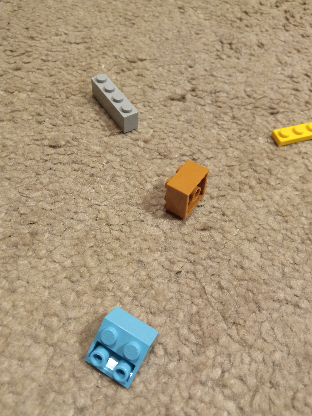

Edges Image 0


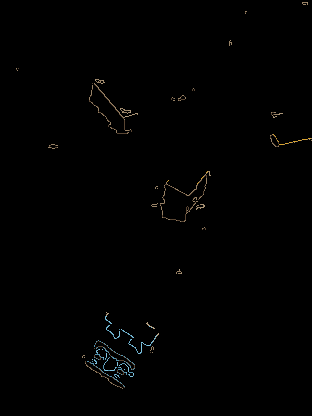

Edges Image 1


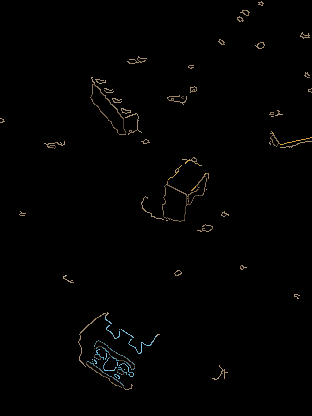

Edges Image 2


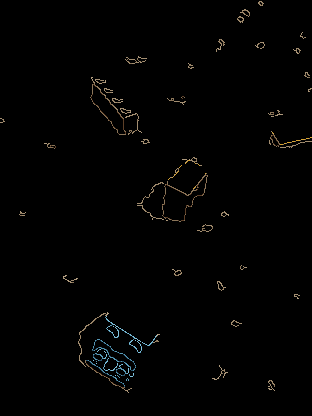

Edges Image 3


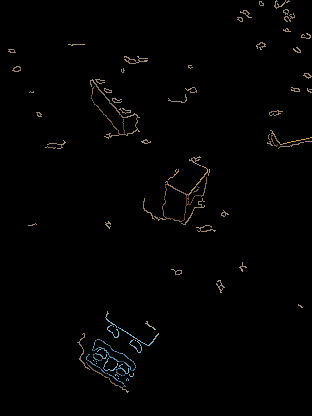

Edges Image 4


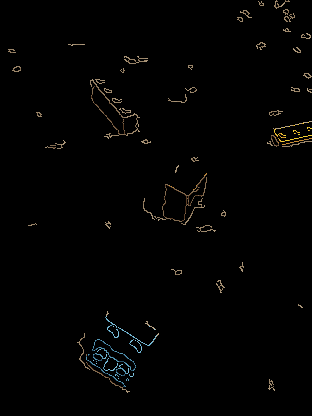

Edges Image 5


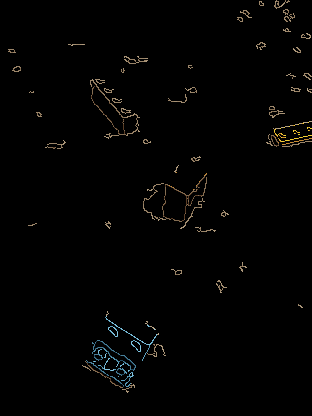

Edges Image 6


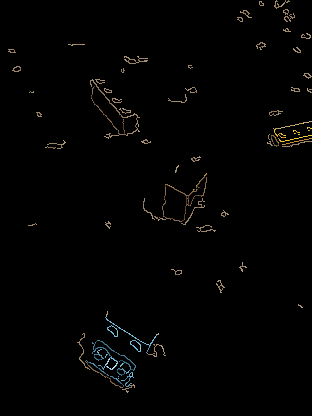

Edges Image 7


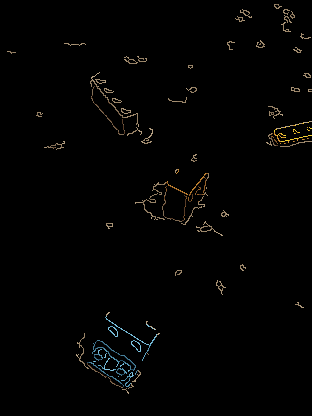

Edges Image 8


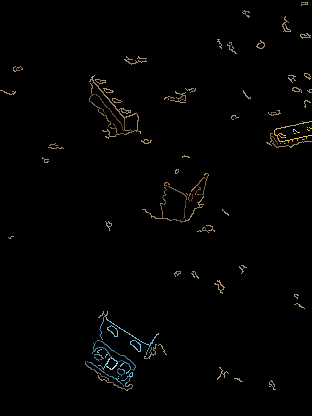

Edges Image 9


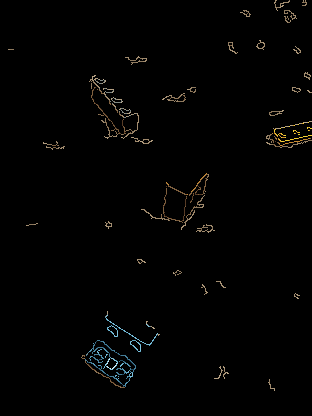

Edges Image 10


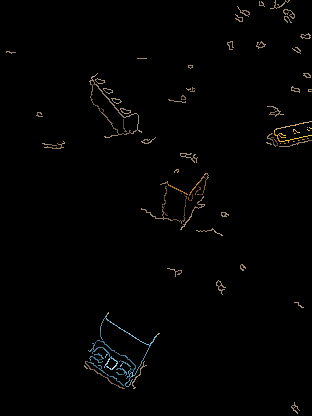

Edges Image 11


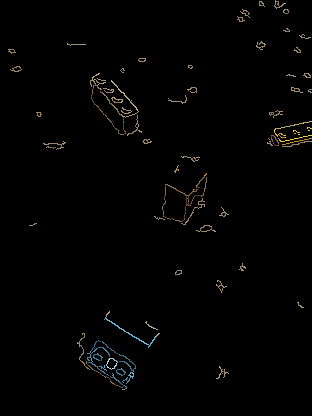

Final Edges Image


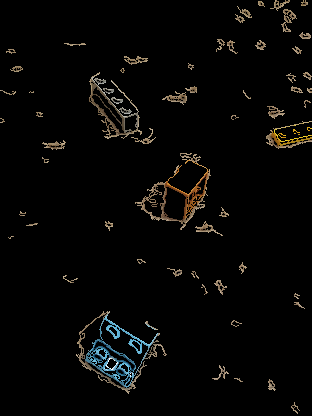

Contours of the Edges


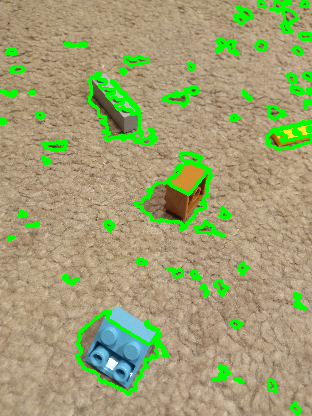

Bounding Boxes: 16


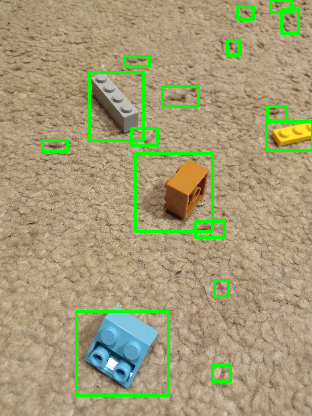

Lego Count: 16 | 4


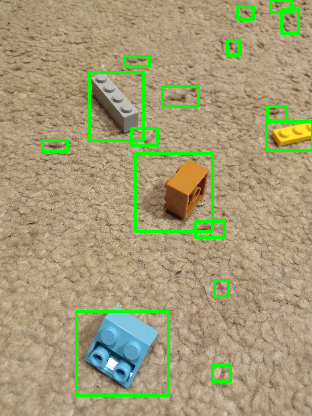

In [410]:
_ = model(37, True, True)

## Applying the model to all images


======================== Image 0 ========================



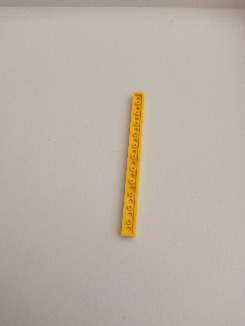

Error in Lego Count - Guessed: 0 | Actual: 1 legos

======================== Image 1 ========================



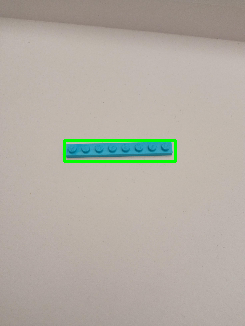

Perfect guess!

======================== Image 2 ========================



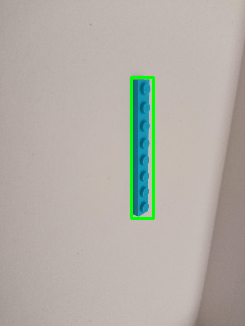

Perfect guess!

======================== Image 3 ========================



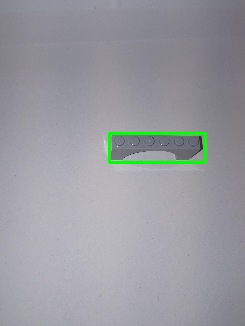

Perfect guess!

======================== Image 4 ========================



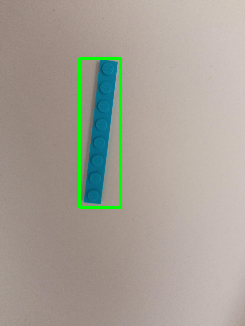

Perfect guess!

======================== Image 5 ========================



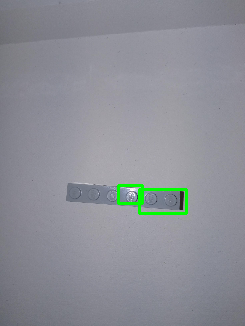

Error in Lego Count - Guessed: 2 | Actual: 1 legos

======================== Image 6 ========================



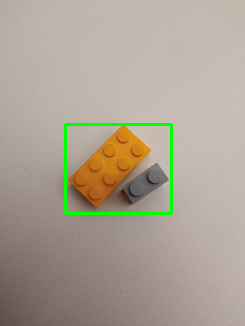

Error in Lego Count - Guessed: 1 | Actual: 2 legos

======================== Image 7 ========================



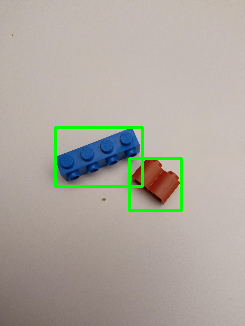

Perfect guess!

======================== Image 8 ========================



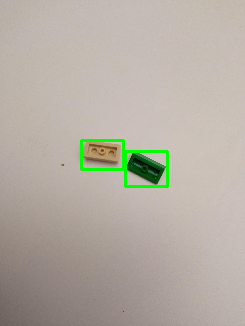

Perfect guess!

======================== Image 9 ========================



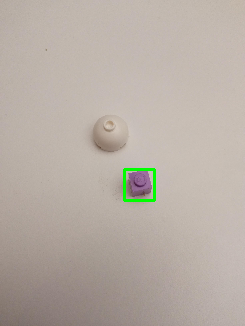

Error in Lego Count - Guessed: 1 | Actual: 2 legos

======================== Image 10 ========================



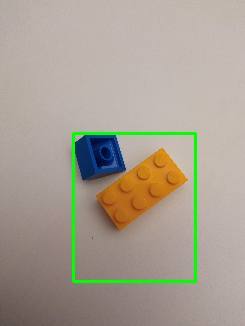

Error in Lego Count - Guessed: 1 | Actual: 2 legos

======================== Image 11 ========================



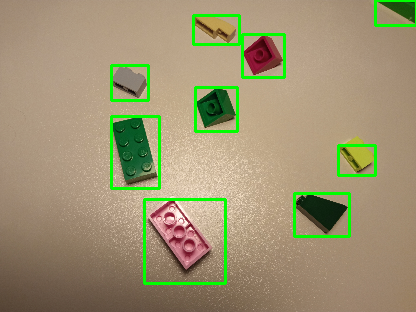

Perfect guess!

======================== Image 12 ========================



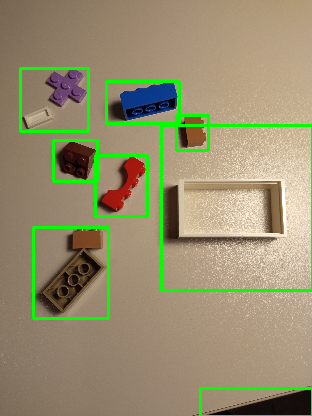

Error in Lego Count - Guessed: 8 | Actual: 9 legos

======================== Image 13 ========================



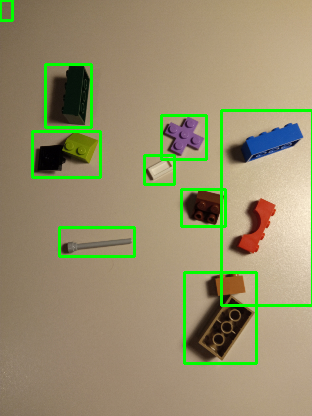

Error in Lego Count - Guessed: 9 | Actual: 11 legos

======================== Image 14 ========================



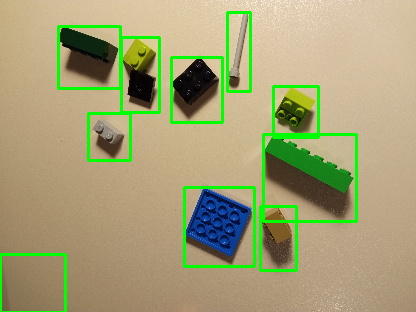

Perfect guess!

======================== Image 15 ========================



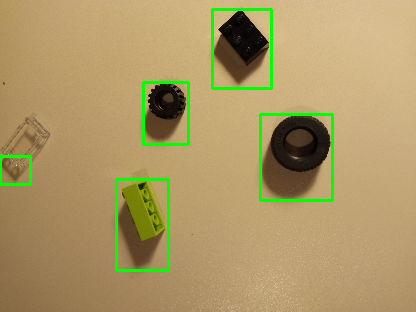

Perfect guess!

======================== Image 16 ========================



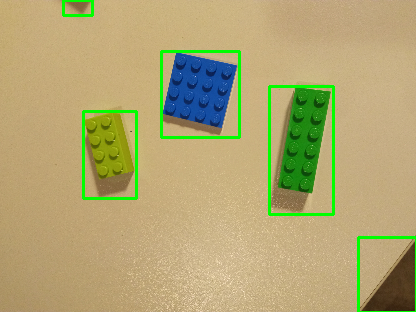

Error in Lego Count - Guessed: 5 | Actual: 3 legos

======================== Image 17 ========================



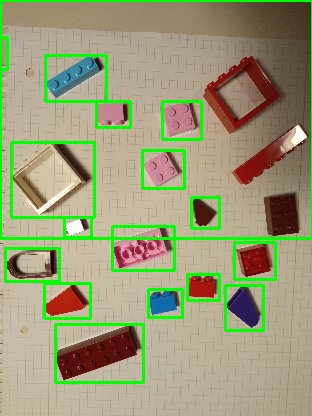

Error in Lego Count - Guessed: 17 | Actual: 18 legos

======================== Image 18 ========================



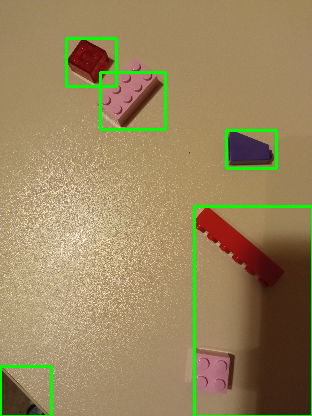

Perfect guess!

======================== Image 19 ========================



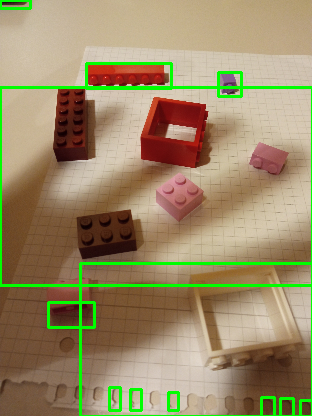

Error in Lego Count - Guessed: 12 | Actual: 9 legos

======================== Image 20 ========================



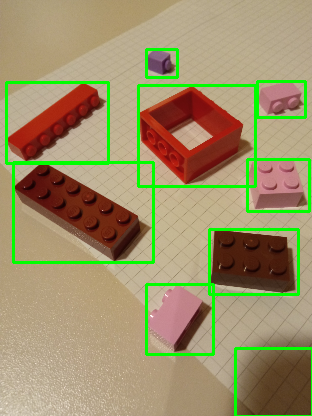

Error in Lego Count - Guessed: 9 | Actual: 8 legos

======================== Image 21 ========================



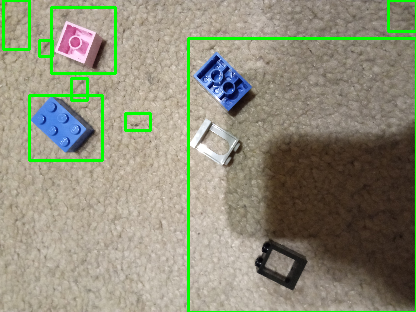

Error in Lego Count - Guessed: 8 | Actual: 5 legos

======================== Image 22 ========================



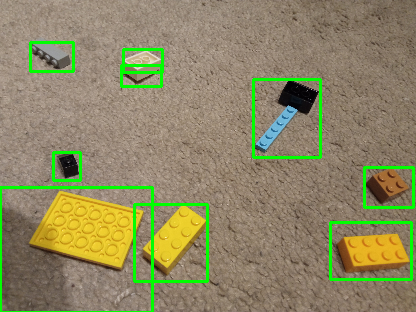

Perfect guess!

======================== Image 23 ========================



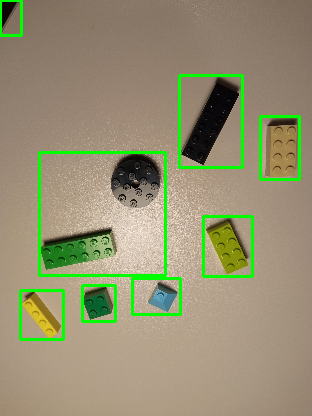

Perfect guess!

======================== Image 24 ========================



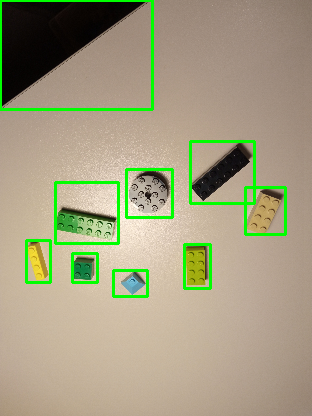

Error in Lego Count - Guessed: 9 | Actual: 8 legos

======================== Image 25 ========================



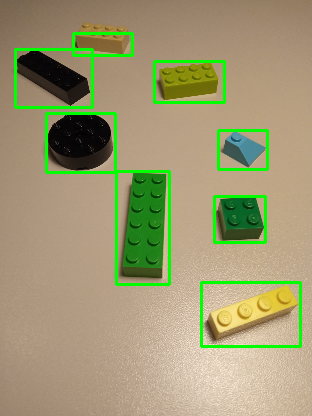

Perfect guess!

======================== Image 26 ========================



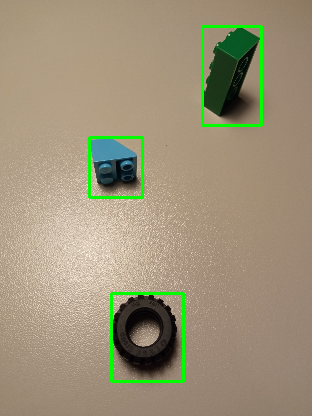

Perfect guess!

======================== Image 27 ========================



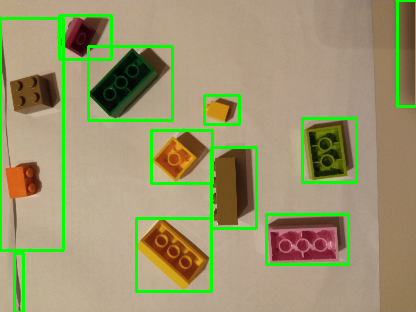

Error in Lego Count - Guessed: 11 | Actual: 10 legos

======================== Image 28 ========================



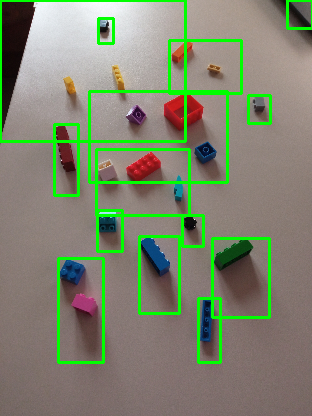

Error in Lego Count - Guessed: 14 | Actual: 20 legos

======================== Image 29 ========================



KeyboardInterrupt: 

In [411]:
def evaluate_model(debug=False, onlyCheckingNums=False):
    total_lego_error = 0
    total_color_error = 0
    total_lego = 0
    total_color = 0
    
    error_lego_ids = []

    for i in range(0, 50):
        print(f"\n======================== Image {i} ========================\n")
        piece_count, color_count, num_legos_guess, num_colors_guess, num_legos_error, num_colors_error = model(i, False, onlyCheckingNums)
        
        if debug:
            if(num_legos_error > 0):
                print(f"Error in Lego Count - Guessed: {num_legos_guess} | Actual: {piece_count} legos")
                error_lego_ids.append(i)
                
            if(num_colors_error > 0):
                print(f"Error in Lego Color - Guessed: {num_colors_guess} | Actual: {color_count} colors")
                error_lego_ids.append(i)
            if num_legos_error == 0 and num_colors_error == 0:
                print("Perfect guess!")
            
        total_lego_error += num_legos_error
        total_color_error += num_colors_error
        total_lego += piece_count
        total_color += color_count
     
    if debug:    
        print(f"\n\n======================== TOTAL RESULTS ========================")   
        print(f"Total Lego Error: {total_lego_error} | {total_lego}")
        print(f"Total Color Error: {total_color_error} | {total_color}")
        print("Num of images with errors: " + str(len(error_lego_ids)))
        print("Error images: " + str(error_lego_ids))
        print("===============================================================")
        
    return total_lego_error, total_color_error, error_lego_ids

_ = evaluate_model(True, True)